# KBO Projections Preprocessing

My goal in this step is to create a cleaned development dataset ready for modeling. I had a lot of counting stats that I already transformed in the EDA step, so a lot of the data is close to ready to use. To demonstrate the principles of preprocessing, I have replicated those steps I previously took in the EDA section below.

Also a reminder that the ultimate goal is to project a player's HR, BA, and RBI.

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('KBO_Projections_Data_Clean.csv')

In [3]:
# transform counting stats to_rates
counts = ['H', 'TB', 'R', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'GDP', 'HBP', 'SH', 'SF', 'IBB']
for column in counts:
    df[column] = df[column].divide(df['PA'])
    df.rename(columns={column : (column + "_rate")}, inplace=True)

In [4]:
# remove AB in favor of PA
df.drop('AB', inplace=True, axis=1)

In [5]:
# H_rate is the same thing as BA, and TB_rate is the same thing as SLG so we will drop them
df.drop(['H_rate', 'TB_rate'], axis=1, inplace=True)

In [6]:
# Gs is functionally similar to PA, and OPS naturally collinear since it is simply OBP + SLG, so dropping them here
df.drop(['G', 'OPS'], axis=1, inplace=True)

In [7]:
df.head()

,Name,Team,Batting Stance,Age,PA,R_rate,2B_rate,3B_rate,HR_rate,RBI_rate,...,SO_rate,BA,OBP,SLG,GDP_rate,HBP_rate,SH_rate,SF_rate,IBB_rate,Season
0,Gweon Su An,Doosan Bears,Unknown,27,16,0.250000,0.000000,0.000000,0.000000,0.062500,...,0.187500,0.200,0.250,0.200,0.062500,0.000000,0.000000,0.000000,0.000000,2020
1,Ju-hwan Choi,Doosan Bears,Left-Handed,32,114,0.122807,0.061404,0.000000,0.052632,0.184211,...,0.122807,0.262,0.316,0.505,0.026316,0.017544,0.000000,0.017544,0.008772,2020
2,Sang-ho Chung,Doosan Bears,Right-Handed,37,34,0.000000,0.088235,0.000000,0.000000,0.088235,...,0.323529,0.188,0.182,0.281,0.058824,0.000000,0.029412,0.029412,0.000000,2020
3,Soo-bin Chung,Doosan Bears,Left-Handed,29,110,0.145455,0.036364,0.009091,0.000000,0.090909,...,0.118182,0.270,0.318,0.330,0.009091,0.000000,0.027273,0.000000,0.000000,2020
4,Jose Miguel Fernandez,Doosan Bears,Left-Handed,32,139,0.172662,0.064748,0.000000,0.035971,0.201439,...,0.086331,0.411,0.453,0.605,0.035971,0.007194,0.000000,0.021583,0.000000,2020


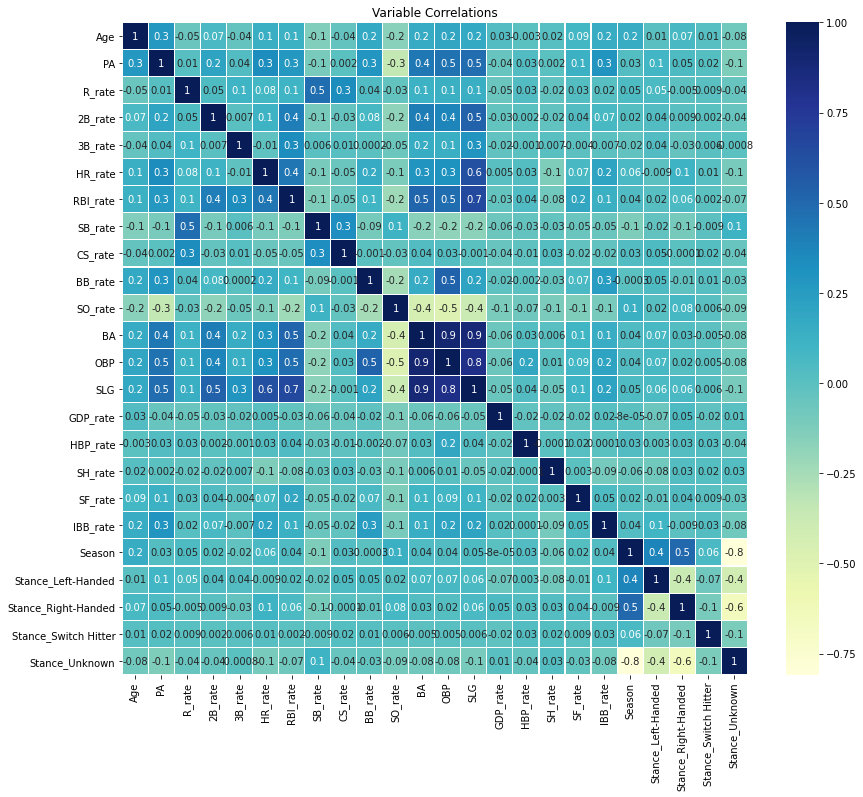

In [8]:
# Dummies for Batting Stance
df_dummies = pd.concat([df,pd.get_dummies(df['Batting Stance'],prefix='Stance')],axis=1).drop(['Batting Stance'],axis=1)

# Batting Stance dummies correlation matrix heatmap
_ = plt.figure(figsize=(14,12))
_ = sns.heatmap(df_dummies.corr(), linewidths=.1, cmap="YlGnBu", annot=True, fmt=".1g")
_ = plt.title("Variable Correlations")
plt.show()

I will not be including batting stance (or its dummy variables) going forward because over a third of our observations (3,354) have Batting Stance 'Unknown'. But the _slight_ variations in correlation with RBI_rate, OBP, BA SO_rate, and GDP_rate depending on left- or right- handed batting stance are neat to observe!

In [9]:
df.drop(['Batting Stance'], axis=1, inplace=True)

In [10]:
# drop names, team columns
df.drop(['Name','Team'], axis=1, inplace=True)

In [11]:
df.to_csv("KBO_Projections_Data_Modeling.csv")

## Train Test Split, Standard Scaler

Because the goal of the project is to project full season performance from partial season performance, I will be splitting based on the season column, withholding the 2020 season for testing. I will then drop the season column, since it serves more as a nominal column for the sake of the specified projections. I am performing this split before fitting and applying the standard scaler to the rest of the data to avoid data leakage.

In [11]:
pd.set_option('mode.chained_assignment',None)
test = df[df['Season']==2020]
train = df[df['Season']!=2020]
test.drop(['Season'],axis=1,inplace=True)
train.drop(['Season'],axis=1,inplace=True)

In [12]:
X_train = train.drop(['RBI_rate','HR_rate','BA'],axis=1)
X_test = test.drop(['RBI_rate','HR_rate','BA'],axis=1)
y_train = train[['RBI_rate','HR_rate','BA']]
y_test = test[['RBI_rate','HR_rate','BA']]

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Of note: I have multiple response variables. I will likely model them individually.